# Kalman Filter 

In [142]:
# include libraries
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Needed Functions

In [143]:
def CSV_Read_Lidar_data(data_path):
    rows = []
    with open(data_path, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)

    dataframe = pd.DataFrame([rows[0], rows[1], rows[2], rows[3]], ['Rho', 'Alpha', 'X', 'Y'])

    return dataframe

In [144]:
def covarience_line_fitting(points_in_line, line_alpha_rho, sigma_angle=0, sigma_dist=.005):
    sigma_angle = sigma_angle * np.ones(len(points_in_line))
    sigma_dist = sigma_dist * np.ones(len(points_in_line))

    data = np.array(points_in_line)

    #INPUIT IS X AND Y POINTS WITHIN A LINE
    dist = line_alpha_rho[1]  # whatever positions stores the distances from 0,0
    angle = line_alpha_rho[0]  # whatever positions stores the angles with the x axis
    
    x = data[:,0]
    y = data[:,1]

    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n

    S_x2 = sum((x - x_bar) ** 2)
    S_y2 = sum((y - y_bar) ** 2)
    S_xy = sum((x - x_bar) * (y - y_bar))

    # line paramters based on inputs data
    alpha = 0.5 * math.atan2(-2 * S_xy, S_y2 - S_x2)
    rho = x_bar * math.cos(alpha) + y_bar * math.sin(alpha)

    C_l = np.zeros(2)
    for i in range(0, n - 1):
        # The covariance of the measurement
        C_m = np.array([[sigma_angle[i], 0],
                        [0, sigma_dist[i]]])
        A = np.zeros((2, 2))

        # The jacobian of the line fit with respect to x and y
        A[1, 0] = ((y_bar - y[i]) * (S_y2 - S_x2) + 2 * S_xy * (x_bar - x[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy ** 2)

        A[1, 1] = ((x_bar - x[i]) * (S_y2 - S_x2) - 2 * S_xy * (y_bar - y[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy **2)

        A[0, 0] = math.cos(alpha) / n - x_bar * math.sin(alpha) * A[1, 0] + y_bar * math.cos(alpha) * A[1, 0]
        A[0, 1] = math.sin(alpha) / n - x_bar * math.sin(alpha) * A[1, 1] + y_bar * math.cos(alpha) * A[1, 1]

        # Jacobian of function converting dist and angle to x and y

        B = np.array([[math.cos(angle), -dist * math.sin(angle)],
                      [math.sin(angle), dist * math.cos(angle)]])
        J = A @ B
        C_l = C_l + J * C_m * J.T

    return rho, alpha, C_l

In [145]:
# Bunch of algorithms for split and merge

def GetPolar(X, Y):
    # center the data
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    # fit line through the first and last point (X and Y contains 2 points, start and end of the line)
    k, n = np.polyfit(X, Y, 1)
    alpha = math.atan(-1 / k)  # in radians
    ro = n / (math.sin(alpha) - k * math.cos(alpha))
    return ro, alpha

def Cartesian2Polar(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return r, phi

def CheckPolar(ro, alpha):
    if ro < 0:
        alpha = alpha + math.pi
        if alpha > math.pi:
            alpha = alpha - 2 * math.pi
        ro = -ro
    return ro, alpha

def getDistance(P, Ps, Pe):  # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)
    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), np.linalg.norm(Pe - Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i, :], P[0, :], P[-1, :])
        if (d > dmax):
            index = i
            dmax = d
    return dmax, index

def points_within_radius(mainpoint, points, r):
    result = []
    for point in points:
        if math.dist(mainpoint, point) <= r:
            result.append(point)
    return result

def gap_detection(lines, points, threshold):
    good_lines = []
    points_in_thresh_total = []
    for i in range(len(lines)):
        # get point 1 and point 2 of the line
        point_1 = lines[i][0]
        point_2 = lines[i][1]

        # get the distance of the line, then take a certain percentage of it (remember its based off both sides)
        line_dist = math.dist(point_2, point_1)
        r = line_dist / 2 * 0.10
        # print(r)

        # check all the points to see if they fall in theshold, store if they do
        points_in_thresh = []

        for j in range(len(points)):
            # distance = point_to_line_distance(points[j], lines[i])
            distance = getDistance(points[j], lines[i][0], lines[i][1])
            if distance <= (threshold * 1):
                # if distance < r:
                points_in_thresh.append(points[j])
        
        if len(points_in_thresh) <= 5 and line_dist <= 0.3:
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
            continue

        # check to see what % of points are between the threshold of the first and last point (might need my own threshold)
        p1_points = points_within_radius(point_1, points_in_thresh, r)
        p2_points = points_within_radius(point_2, points_in_thresh, r)
        # print(len(p1_points))
        # print(len(p2_points))
        # print(len(points_in_thresh))

        percent_in_radius = (len(p1_points) + len(p2_points)) / (len(points_in_thresh))
        # print(percent_in_radius)

        if percent_in_radius <= 0.40:
            # print("good line")
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
        # else:
        #     print("bad line")
        # plt.show()
        # print("\n")
        
    return good_lines, points_in_thresh_total

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)
    if d > threshold:
        P1 = SplitAndMerge(P[:ind + 1, :], threshold)  # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold)  # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))
    return points

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

def Algorithm_split_and_merge(inputdataframe, threshold=0.3, plot=False):

    P = np.array([list(inputdataframe['X']), list(inputdataframe['Y'])]).T

    points = SplitAndMerge(P, threshold)

    lines = []
    for i in range(len(points) - 1):
        lines.append([points[i], points[i + 1]])
        # plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], '-o')
    # final_lines = lines
    final_lines, points_in_line = gap_detection(lines, P, threshold)

    # flatten it to get the shitty points
    flat_list = flatten(final_lines)
    flat_list.append(flat_list[0])
    flat_list = np.array(flat_list)

    #convert from xy back to alpha rho
    alpha_rho = []
    for i in range(len(final_lines)):
        alpha, rho = GetPolar([final_lines[i][0][0], final_lines[i][1][0]], [final_lines[i][0][1], final_lines[i][1][1]])
        alpha_rho.append([alpha, rho])

    if plot==True:
        # plt.figure()
        # plt.title('og')
        # plt.scatter(P[:, 0], P[:, 1], c='black')
        # plt.plot(points[:, 0], points[:, 1])

        # plt.figure()
        # plt.title('with gap detection')
        # plt.scatter(P[:, 0], P[:, 1], c='black')
        # plt.plot(flat_list[:, 0], flat_list[:, 1], '-o')

        plt.figure()
        plt.title('actual Lines')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        for i in range(len(final_lines)):
            tmp = np.array(final_lines[i])
            plt.plot(tmp[:, 0], tmp[:, 1], '-o')
        # print(len(lines))
        # print(len(final_lines))
        plt.scatter(0, 0, c='red')  # replace this with the origin point
        plt.show()

    return final_lines, points_in_line, alpha_rho

In [146]:
def matching(z_hat_t,z_t,R_t,H_j,P_hat_t,g):

    matches = []
    v_t_matches = []
    sigmas_matches = []
    H_matches = []
    #initializedng vt

    v_t = np.zeros((2,1,len(z_t),len(z_hat_t)))
    sigma_itt = np.zeros((2,2,len(z_t),len(z_hat_t)))
    #This could be vectorized or whatever but i think itll be okay
    for i in range(len(z_t)):
        for j in range(len(z_hat_t)):
            v_t[:,0,i,j] = z_t[:,0,i] - z_hat_t[:,0,j]
            
            sigma_itt[:,:,i,j] = H_j[:,:,j] @ P_hat_t @ H_j[:,:,j].T + R_t[i]
    # Mahalanobis distance

   
    for i in range(len(z_t)):
        mah_dist_best = g**2
        save_latch = False
        for j in range(len(z_hat_t)):
            v_ = v_t[:,:,i,j]
            sigma_ = sigma_itt[:,:,i,j]
            # print(v_)
            # print(v_.T)
            mah_dist = v_.T @ sigma_ @ v_
            # print(mah_dist)
            if mah_dist <= g**2:
                
                if mah_dist <= mah_dist_best:
                    ibest = i
                    jbest = j
                    save_latch = True
        if save_latch == True:

            matches.append([ibest,j])
            v_t_matches.append(v_t[:,:,ibest,jbest])
            sigmas_matches.append(sigma_itt[:,:,ibest,jbest])
            H_matches.append(H_j[:,:,jbest])
                
    return matches, v_t_matches, sigmas_matches,H_matches

In [147]:
def pos_estimation(H_t, x_hat, v_t,P_t_hat,sigmas):
 
    #for number of matched lines
    for i in range(len(H_t)):
        K_t = P_t_hat @ H_t[i].T @ np.linalg.pinv(sigmas[i])
        # print(f'H_t = {H_t}')
        P_t = P_t_hat - K_t @ sigmas[i] @ K_t.T

        x_t = x_hat + K_t @ v_t[i]
        x_hat = x_t

    if len(H_t) == 0:
        x_t = x_hat
        P_t = P_t_hat
        return x_t, P_t

    
    return x_t, P_t

In [148]:
def pos_estimation_v2(H_t, x_hat, v_t,P_t_hat,sigma):
 
    #for number of matched lines
    
    K_t = P_t_hat @ H_t.T @ np.linalg.pinv(sigma)
    # print(f'H_t = {H_t}')
    P_t = P_t_hat - K_t @ sigma @ K_t.T

    x_t = x_hat + K_t @ v_t
    x_hat = x_t

   
    return x_t, P_t

In [149]:
def measurement_prediction(x_hat, gt_map_df):
    """
    The measurements needs to take the MAP data and move the lines into the Robts frame (from world) THEN match lines together or something
    x_hat = 
    map = gt map
    data = observed map data
    """
    N = int(gt_map_df.shape[1])
    z_hat_t = np.zeros([2, 1, N]) # The pridiction of what the Lines detected should be, from map
    alpha_map = gt_map_df.loc['Alpha'].astype(float)
    rho_map = gt_map_df.loc['rhos'].astype(float)

    z_hat_t[0,0,:] = alpha_map[:] - x_hat[2] # removing the robots orientation in the world to rotate the line angles into frame
    z_hat_t[1,0,:] = rho_map[:]-x_hat[0]*np.cos(alpha_map[:])+x_hat[1]*np.sin(alpha_map[:]) # translation portion for the lines

    H_j = np.zeros([2,3,N])

    for k in range(N):
        H_j[:,:,k] = np.array([[0,  0,  -1],  
                    [-np.cos(alpha_map[k]), -np.sin(alpha_map[k]), 0]])  #it might not be able to handle this notation. Could easily be a loop

    return z_hat_t,H_j

In [150]:
# TODO pos_t_minus1 needs to be updated to previous x_hat_t after initial time step -Rob

In [151]:
def position_prediction(pos_t_minus1, delta_sl, delta_sr, b,P_t_minus1):

    delta_sl
    delta_sr

    theta_t_minus1 = pos_t_minus1[2]
  
    x_hat = np.empty((3,1))

    

    # This is previous postion + estimate of future position
    x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr-delta_sl) / b]]))
    
    delta_s = (delta_sr+delta_sl)/2
    delta_theta = (delta_sr-delta_sl) / b

    k_r =  .001
    k_l =  .001

    Q_t  = np.array([[k_r * abs(delta_sr), 0],
                    [0, k_l * abs(delta_sl) ]])
    F_deltarl = np.array([  [.5*math.cos(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2),.5*math.cos(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2)],
                            [.5*math.sin(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2),.5*math.sin(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2)],
                            [1/b,-1/b]])

    F_k_minus_1 = np.array([[1, 0, -delta_s*math.sin(theta_t_minus1+delta_theta/2)],
                            [0, 1,  delta_s*math.cos(theta_t_minus1+delta_theta/2)],
                            [0, 0, 1]])
    
    #TODO PUT IN THE FU MATRICXZ
    # @ is matrix multiplication
    P_t_minus1_2 = P_t_minus1 * np.identity(3)
    P_hat_t = F_k_minus_1 @ P_t_minus1_2 @ F_k_minus_1.T + F_deltarl@ Q_t @ F_deltarl.T
    # pos_t_minus1 = x_hat
    return x_hat, P_hat_t

# Initializing map


Ground Truth Map Generation

In [152]:
file_path = 'Data_Readers_Writers/Data/'
file_name = 'CornerBox_GT_LineData'
# file_name = 'Downstairsdata_GT_LineData'

data_path = file_path + file_name + '.pkl'

ground_truth_df = pd.read_pickle(data_path)
ground_truth_df = ground_truth_df.T
ground_truth_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Alpha,-1.570583,0.013796,-1.202097,-0.001523,-1.144177,0.25042,1.565205,-0.18206,0.286476,1.564789,...,-0.178559,0.321536,1.563927,0.741174,-0.678087,0.082054,1.564416,-0.16879,-1.379399,-0.001523
rhos,0.543678,0.771249,0.52869,0.962502,-0.247673,0.918286,0.962034,-0.224853,0.012699,0.961871,...,-0.220133,0.039714,0.961534,-0.087702,-0.597401,-0.888299,-0.54455,0.826869,0.398343,0.962502
Covariance,"[[1.0845666236477663e-11, 0.0], [0.0, 5.424902...","[[2.66691057082647e-06, 0.0], [0.0, 1.34004501...","[[1.9080934501723668e-07, 0.0], [0.0, 5.223160...","[[3.0996483233241354e-06, 0.0], [0.0, 2.604640...","[[1.2246449742632525e-06, 0.0], [0.0, 3.820635...","[[2.590565857379792e-06, 0.0], [0.0, 1.4013409...","[[6.241879659461478e-11, 0.0], [0.0, 6.3929454...","[[3.964230288805714e-06, 0.0], [0.0, 3.9211947...","[[2.944472783525905e-06, 0.0], [0.0, 2.3882672...","[[6.9903740852197e-11, 0.0], [0.0, 6.317269419...",...,"[[3.889302985645308e-06, 0.0], [0.0, 3.6270535...","[[2.9071032107015746e-06, 0.0], [0.0, 3.580915...","[[8.688418052285826e-11, 0.0], [0.0, 6.2736608...","[[1.4678246365814453e-06, 0.0], [0.0, 5.362264...","[[1.1515112933472732e-06, 0.0], [0.0, 7.174792...","[[4.3806597914444845e-06, 0.0], [0.0, 1.867100...","[[3.816302386140735e-11, 0.0], [0.0, 5.5378565...","[[2.9949707007093343e-06, 0.0], [0.0, 2.620612...","[[1.0175952975163658e-07, 0.0], [0.0, 4.494168...","[[3.0996483233241354e-06, 0.0], [0.0, 6.128878..."
Lines_(endpoints),"[[0.003182207131548859, -0.5479907385326418], ...","[[0.7836685853918443, -0.5440400178217623], [0...","[[0.7855127587300176, -0.24218536242286426], [...","[[0.9656543801801287, -0.16706781683784871], [...","[[0.9645261286188632, 0.7206284327069791], [0....","[[0.762146771846806, 0.6192384718768514], [0.6...","[[0.6971847542143262, 0.961913370520321], [-0....","[[-0.09558584750092784, 0.9652789240739567], [...","[[-0.15164097361877799, 0.6094169684804307], [...","[[-0.25322569973948844, 0.9694744418446715], [...",...,"[[-0.08997891179347313, 0.9658177110284882], [...","[[-0.14501351578745636, 0.613083252283744], [-...","[[-0.2588511174747298, 0.967987627700207], [-0...","[[-0.9842890963981363, 0.975792538304923], [-0...","[[-0.4559920412790662, 0.39303340315258534], [...","[[-0.8869557521736274, -0.16405338079604992], ...","[[-0.8376826778962353, -0.5461572403187492], [...","[[0.7529367006540231, -0.5694052472637188], [0...","[[0.7855127587300176, -0.24218536242286426], [...","[[0.9588068099505981, -0.21216382368642228], [..."
Points_within_line,"[[0.003182207131548859, -0.5479907385326418], ...","[[0.6909392733079545, -0.548203403774787], [0....","[[0.003182207131548859, -0.5479907385326418], ...","[[0.9615136000332805, -0.1894508757833393], [0...","[[0.9671785361642349, 0.614720865573988], [0.9...","[[0.9615136000332805, -0.1894508757833393], [0...","[[0.7700085787009162, 0.867575190567735], [0.7...","[[0.005625325936642285, 0.9659836413324144], [...","[[0.07377275536692746, -0.5490661187467916], [...","[[0.7700085787009162, 0.867575190567735], [0.7...",...,"[[0.011234647433104783, 0.9659346884291805], [...","[[0.12300987361236558, -0.5483726330986869], [...","[[0.7696884896123853, 0.8571368121253427], [0....","[[0.2669451382543872, -0.5484891162225429], [0...","[[0.11264989285916782, 0.9654501578023832], [0...","[[-0.9517898737516032, 0.977032207637287], [-0...","[[0.003182207131548859, -0.5479907385326418], ...","[[0.6548431459343014, -0.5512861914063829], [0...","[[0.7815904697007064, -0.33914647930194863], [...","[[0.9615136000332805, -0.1894508757833393], [0..."


# 1. Robot Position Prediction

In [153]:
'''
robot pos prediction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
# Some values that are global


b = .235 # distance between robots wheels (meters)
wheel_radius = 0.072 # radius of the actual wheel (meters)

"""
These are the uncertainties in the are error constants representing the 
nondeterministic parameters of the motor drive and the wheel-floor interaction. Probably can be found in DOC or just tune for it
"""

# Pull these from ros, page 337, displacewmnt of left and right wheel
# ut = [delta_sl, delta_sr].T
#TODO When converting to robot version, get these update every time step
delta_sl = 0.0
delta_sr = 0.0

# pos_t_minus1 is the [x_t-1, y_t-1, theta_t-1] position of the robot x_t-1
# the robot drives forward with the control input ut (above) to a position vector xt
# Both are world frames
#TODO get a value for this
pos_t_minus1 = np.array([[0],
                        [0],
                        [0]])
# initialize covarience matrix TODO intiialize this beter
# P_t_minus1 = 0.1
P_t_minus1 = np.array([[9, 0, 0],
                    [0, 9, 0],                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                    [0, 0, .9]])

g = 5

# 2. Observation

In [154]:
# Load datapath and put into dataframe
# path to csv data
data_path = 'Data_Readers_Writers/Data/CornerBox_scan_data_organized.csv'
# data_path = 'Data_Readers_Writers/Data/DownstairsScanV2_scan_data_organized.csv'

tmp_df = pd.read_csv(data_path)

#read and turn to list
lowrange = 0
highrange = 1070

scan_df = []
for i in range(int(tmp_df.shape[0]/1070)):
    lowrange = 0 + 1070 * i
    highrange = lowrange + 1070
    scan_df.append(tmp_df.iloc[lowrange:highrange, :])

# Delete any column that has an inf in the rho spot
for i in range(len(scan_df)):
    inf_cols = scan_df[i]['Rho'][np.isfinite(scan_df[i]['Rho'])]
    # print(inf_cols.index)
    scan_df[i] = scan_df[i].T[inf_cols.index].T.reset_index(drop=True)
scan_df

[     Unnamed: 0       Rho     Alpha         X         Y
 0           0.0  1.658160 -1.233977  0.003182 -0.547991
 1           1.0  1.652681 -1.232816  0.006364 -0.547963
 2           2.0  1.647203 -1.231647  0.009546 -0.547917
 3           3.0  1.641728 -1.230470  0.012728 -0.547852
 4           4.0  1.636256 -1.229286  0.015909 -0.547769
 ..          ...       ...       ...       ...       ...
 970      1065.0  4.652071  1.452292 -0.051046 -0.547626
 971      1066.0  4.657838  1.452440 -0.047865 -0.547913
 972      1067.0  4.663604  1.452587 -0.044682 -0.548182
 973      1068.0  4.669371  1.452733 -0.041498 -0.548432
 974      1069.0  4.674902  1.453305 -0.038174 -0.546669
 
 [975 rows x 5 columns],
      Unnamed: 0       Rho     Alpha         X         Y
 0        1070.0  4.680669  1.453450 -0.034999 -0.546881
 1        1071.0  4.686436  1.453595 -0.031822 -0.547075
 2        1072.0  4.692438  1.453316 -0.028749 -0.549248
 3        1073.0  4.698205  1.453461 -0.025560 -0.549406
 4  

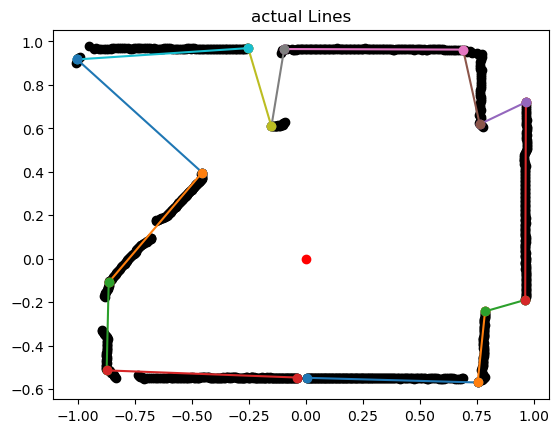

[array([[0.        , 0.        ],
       [0.        , 0.00017773]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.43241341e-08]]), array([[0.       , 0.       ],
       [0.       , 0.0001671]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.18559066e-13]]), array([[0.       , 0.       ],
       [0.       , 0.0001127]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.19194368e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00019649]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.12850779e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.35822954e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00019486]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.42768102e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.21092957e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.40526015e-10

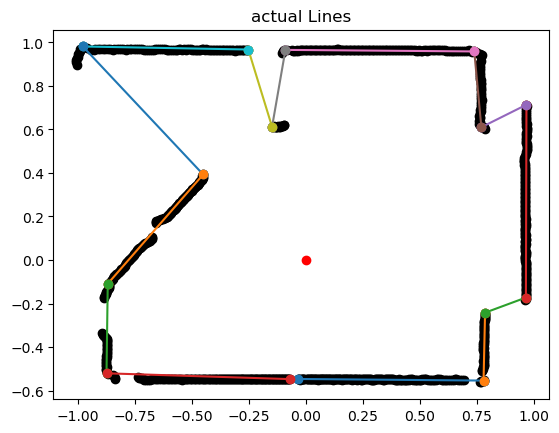

[array([[0.        , 0.        ],
       [0.        , 0.00019171]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.62023706e-11]]), array([[0.       , 0.       ],
       [0.       , 0.0002032]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.60501347e-13]]), array([[0.        , 0.        ],
       [0.        , 0.00011409]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.43475966e-09]]), array([[0.        , 0.        ],
       [0.        , 0.00017785]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.38267204e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.68774126e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00017374]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.6155793e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.21836611e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.82541517e-10

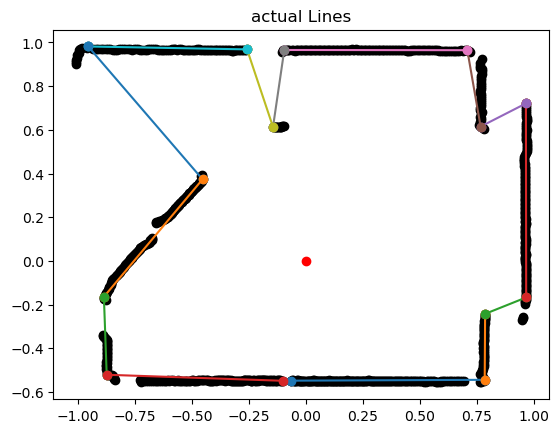

[array([[0.        , 0.        ],
       [0.        , 0.00018704]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.05908703e-12]]), array([[0.        , 0.        ],
       [0.        , 0.00019627]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.01522124e-13]]), array([[0.        , 0.        ],
       [0.        , 0.00011524]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.82579008e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00019545]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.68459789e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.21416403e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00018886]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.31301289e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.07409322e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.6559

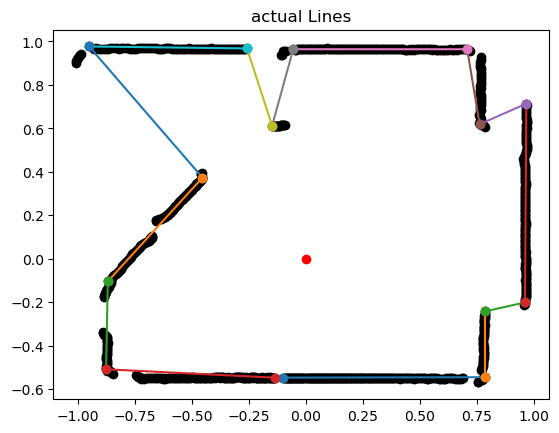

[array([[0.        , 0.        ],
       [0.        , 0.00018912]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.54348259e-14]]), array([[0.        , 0.        ],
       [0.        , 0.00014972]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.41623071e-12]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.90829172e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.75655506e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00020424]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.06648613e-07]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05510656e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00019864]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.43915773e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.33012257e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.0000

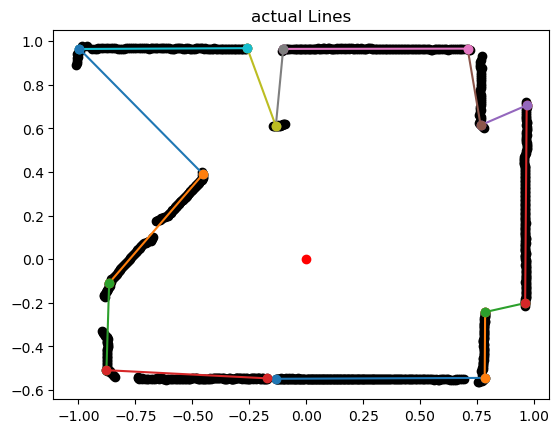

[array([[0.        , 0.        ],
       [0.        , 0.00018685]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.73350055e-12]]), array([[0.        , 0.        ],
       [0.        , 0.00014679]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.87081595e-12]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.57922701e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.65930004e-07]]), array([[0.        , 0.        ],
       [0.        , 0.00019082]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.17943789e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.63484881e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00019212]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.91652941e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.19937684e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.0000

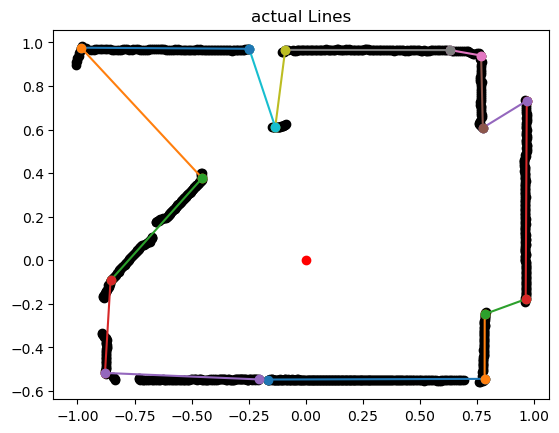

[array([[0.        , 0.        ],
       [0.        , 0.00019471]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.4191058e-13]]), array([[0.        , 0.        ],
       [0.        , 0.00020377]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.25447658e-12]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.13887725e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.77948639e-11]]), array([[0.        , 0.        ],
       [0.        , 0.00173165]]), array([[0.        , 0.        ],
       [0.        , 0.00017958]]), array([[0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.3179339e-08]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.11335377e-06]]), array([[0.        , 0.        ],
       [0.        , 0.00017839]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.57976551e-05]]), array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.30415036e-05

In [155]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


all_xt = []
all_xhat = []
for robot_scans in range(len(scan_df)):
# for robot_scans in range(20):

    # print(f'pos_t_minus1 = {pos_t_minus1}')
    x_hat, P_hat_t = position_prediction(pos_t_minus1, delta_sl, delta_sr, b, P_t_minus1)
    # print(f'x_hat = {x_hat}')
    
    # print(f'p_hat_t = {P_hat_t}')


    '''
    OBSERVATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''

    # Run the split and merge and get covar
    # apply the split and merge algorithm


    Lines, points_in_line, line_alpha_rho = Algorithm_split_and_merge(scan_df[robot_scans].astype(float),threshold=0.1, plot=True)

    # Do covarience line fitting, save data to lists
    alphas = []
    rhos = []
    covars = []
    for i in range(len(points_in_line)):
        rho, alpha, C_l = covarience_line_fitting(points_in_line[i], line_alpha_rho[i])
        # line_info.append([alpha, rho, C_l])
        alphas.append(alpha)
        rhos.append(rho)
        covars.append(C_l)

    print(covars)
    # Create a dataframe with the good info
    all_scan_df = pd.DataFrame([alphas, rhos, covars, Lines, points_in_line], ['Alpha','rhos' ,'Covariance', 'Lines (endpoints)', ' Points within line'])



    # alpha and rho from the lidar data
    z_t = np.array([[all_scan_df.loc['Alpha'].astype(float)],
                [all_scan_df.loc['rhos'].astype(float)]])
    
    # Covariane matrix for eachlinec calculated
    R_t = np.array(all_scan_df.loc['Covariance'])

    '''
    MEASUREMENT PREDICTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    ground_truth_df
    z_hat_t, H_j = measurement_prediction(x_hat, ground_truth_df)


    '''
    MATCHING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
 

    matches, v_t_matches, sigmas_matches, H_j = matching(z_hat_t, z_t, R_t, H_j, P_hat_t, g)

   
    print(matches)
    for match in matches:
        i = match[0]
        j = match[1]
        print('robot_measurement',z_t[:,:,i])
        print('world frame match',z_hat_t[:,:,j])
    
    '''
    ESTIMATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    # x_t, P_t = pos_estimation(H_j, x_hat, v_t_matches, P_hat_t, sigmas_matches)

    for i in range(len(H_j)):
        
        x_t, P_t = pos_estimation_v2(H_j[i], x_hat, v_t_matches[i], P_hat_t, sigmas_matches[i])
        print(x_t-x_hat)
        x_hat = x_t
        P_hat_t = P_t
    
    if len(H_j) < 1:
        P_t = P_hat_t
        x_t = x_hat
    P_t_minus1 = P_t

    pos_t_minus1 = x_t


    
    
    
    # print(f'pos_t_minus1 = {pos_t_minus1}')

    all_xt.append(x_t)
    all_xhat.append(x_hat)

    # print(f'Scan {robot_scans}')
    # print(f'x_t = {x_t}')
    # print(f'x_hat = {x_hat}')
    # print(f'covarience = {P_t}')

    # print('\n')
    # print('\n')

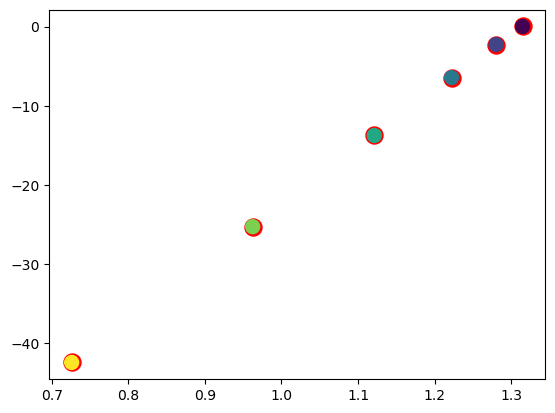

In [156]:
plt.figure()
color = []
for i in range(len(all_xt)):
    
    color.append(i/len(all_xt))
color = np.array(color)
plt.scatter(np.array(all_xhat)[:,0], np.array(all_xhat)[:,1], c='red',s = 150)
plt.scatter(np.array(all_xt)[:,0], np.array(all_xt)[:,1], c=color   ,s=100)
